## 🛠️ Mod5 Data Challenge 1: ETL-in-the-Wild — Cleaning Civic Data for Product Insights

### 🎯 Purpose

Practice applying the "Transform" step of an ETL pipeline using a real-world dataset—NYC 311 Service Requests. You’ll clean, standardize, and engineer features to prep the data for downstream analysis and business reporting.

### 📚 KSBs

K14 – Strategic feature engineering to improve analysis outcomes

S5 – Data transformation techniques in Python

S8 – Uses Pandas for EDA and data manipulation

B4 – Exercises critical judgment about data quality and reliability

B6 – Pursues deeper insights beyond surface-level observations

### Data
Use the **nyc311.csv** file located in your Github's `data` folder within Mod5/DataChallenges.  This is a sample of the originial file looking at just one week of data since the dataset is HUGE.  Read more about the columns [HERE](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9/about_data).   

### 👩‍🏫 Instructor-Led Demo (15 minutes)

#### Step 1:  Load + Preview 
* Read in data

* Show .head(), .info() to examine structure and datatypes

In [1]:
import pandas as pd
df = pd.read_csv("../data/nyc311.csv")

#### Step 2:  Clean up Categorical Variable 

* Normalize Borough & Complaint Type (e.g., strip whitespace, title-case or upper-case values)

* Show .value_counts() before and after cleaning

In [2]:
# Strip whitespace and standardize case
for col in ["Complaint Type", "Borough"]:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

# pick a style (title-case often reads nicely)
df["Complaint Type"] = df['Complaint Type'].str.title()
df["Borough"] = df['Borough'].str.title()

# quick sanity checks
display(df["Complaint Type"].value_counts().head(10))
display(df["Borough"].value_counts())

Complaint Type
Illegal Parking            10654
Noise - Residential         6603
Noise - Street/Sidewalk     4532
Blocked Driveway            3002
Unsanitary Condition        1539
Noise - Commercial          1411
Dirty Condition             1176
Abandoned Vehicle           1050
Street Condition            1032
Noise                       1023
Name: count, dtype: int64

Borough
Brooklyn         17102
Queens           14668
Manhattan        11729
Bronx            10041
Staten Island     2226
Unspecified         49
Name: count, dtype: int64

In [3]:
df.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location
0,66178993,09/17/2025 02:50:56 AM,NaN,DOT,Department of Transportation,Street Condition,Pothole,NaN,10457.0,CROSS BRONX EXPRESSWAY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,66174339,09/17/2025 02:44:55 AM,NaN,DOT,Department of Transportation,Street Condition,Pothole,NaN,10469.0,SEYMOUR AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,66170874,09/17/2025 02:42:45 AM,NaN,DOT,Department of Transportation,Street Condition,Pothole,NaN,10467.0,BOSTON ROAD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,66172189,09/17/2025 01:51:12 AM,NaN,NYPD,New York City Police Department,Illegal Parking,Blocked Sidewalk,Street/Sidewalk,11691.0,13-54 DAVIES ROAD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.599549,-73.748018,"(40.5995492740367, -73.74801784107588)"
4,66175640,09/17/2025 01:50:43 AM,NaN,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,11372.0,89-07 34 AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.754443,-73.878352,"(40.754442992557145, -73.87835236707805)"


#### Step 3:  Feature Engineering

* Convert Created Date to datetime

* Create a new feature: is_weekend based on weekday

In [4]:
df["Created Date"] = pd.to_datetime(df['Created Date'],)

# is_weekend flag
df["is_weekend"] = df['Created Date'].dt.weekday >= 5

### 👩‍💻 Student-Led Section (30 minutes)

#### Task1:  Clean & Filter

* Drop rows with missing Created Date or Closed Date

* Drop duplicate rows

* Filter data to only include one borough (e.g., Brooklyn)

In [8]:
df = df.dropna(subset=['Created Date', 'Closed Date']).copy()


<Axes: >

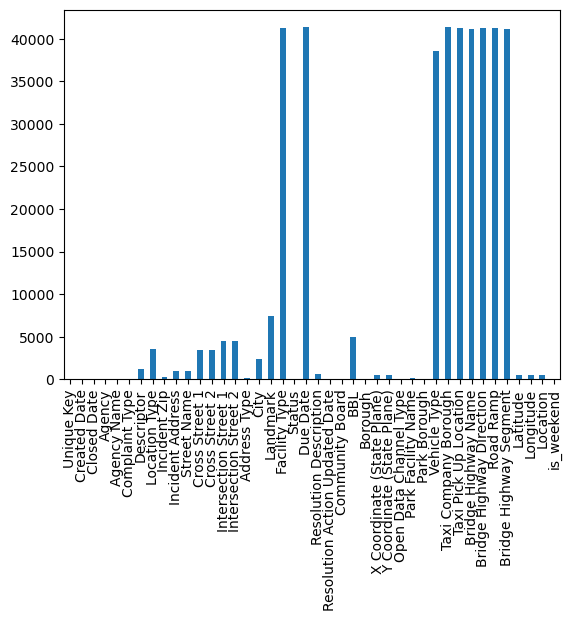

In [10]:
df.isna().sum().plot(kind='bar')

In [12]:
# 1a) Drop rows with missing Created/Closed Date
df = df.dropna(subset=['Created Date', 'Closed Date']).copy()

# 1b) Drop duplicates
df = df.drop_duplicates()

# 1c) Filter to a single borough (STUDENT CHOICE)
borough_name = "Brooklyn"  # e.g., "Brooklyn"
df_b = df[df["Borough"] == borough_name].copy()
df_b.shape

(12553, 42)

#### Task2:  Time Transformations 

* Create a new column `response_time_hrs` = difference between Closed Date and Created Date (in hours)

* Ensure datetime types are properly parsed and timezone-aware (localize to America/New_York → convert to UTC)

In [14]:
# RUN THIS CELL WITHOUT CHANGES!!!! 

LOCAL_TZ = "America/New_York"

def to_utc(series, local_tz=LOCAL_TZ):
    # 1) parse
    s = pd.to_datetime(series, errors="coerce")

    # 2) if naive -> localize; if tz-aware -> skip (KEEP NONE in this if statement)
    if s.dt.tz is None:
        s = s.dt.tz_localize(local_tz, nonexistent="shift_forward", ambiguous="NaT")

    # 3) convert whatever tz it has to UTC
    return s.dt.tz_convert("UTC")

In [20]:
# Convert both columns to utc
df_b["Created Date"] = to_utc(df_b["Created Date"])
df_b["Closed Date"]  = to_utc(df_b['Closed Date'])

# Now compute the response time
delta = df_b['Created Date'] - df_b['Closed Date']
df_b["response_time_hrs"] = delta.dt.total_seconds() / 3600

# Check the data with a .head()
df_b.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location,is_weekend,response_time_hrs
47,66173993,2025-09-17 05:27:57+00:00,2025-09-17 05:29:09+00:00,NYPD,New York City Police Department,Noise - Commercial,Loud Talking,Club/Bar/Restaurant,11237.0,44 WILSON AVENUE,...,NaN,NaN,NaN,NaN,NaN,40.702777,-73.929386,"(40.70277711007218, -73.92938632693719)",False,-0.020000
54,66174271,2025-09-17 05:23:49+00:00,2025-09-17 05:39:28+00:00,NYPD,New York City Police Department,Noise - Residential,Loud Talking,Residential Building/House,11201.0,5 FLEET WALK,...,NaN,NaN,NaN,NaN,NaN,40.695529,-73.981230,"(40.69552909769039, -73.98122967592082)",False,-0.260833
60,66175304,2025-09-17 05:19:15+00:00,2025-09-17 05:44:27+00:00,NYPD,New York City Police Department,Noise - Residential,Banging/Pounding,Residential Building/House,11237.0,1420 DEKALB AVENUE,...,NaN,NaN,NaN,NaN,NaN,40.700229,-73.923229,"(40.700228769188584, -73.92322918276676)",False,-0.420000
62,66171896,2025-09-17 05:16:19+00:00,2025-09-17 05:44:39+00:00,NYPD,New York City Police Department,Noise - Residential,Banging/Pounding,Residential Building/House,11237.0,1420 DEKALB AVENUE,...,NaN,NaN,NaN,NaN,NaN,40.700229,-73.923229,"(40.700228769188584, -73.92322918276676)",False,-0.472222
67,66178958,2025-09-17 05:14:22+00:00,2025-09-17 05:35:03+00:00,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Talking,Street/Sidewalk,11201.0,55 CLARK STREET,...,NaN,NaN,NaN,NaN,NaN,40.697715,-73.993931,"(40.697715303250725, -73.99393054925939)",False,-0.344722


#### Task3:  Feature Engineer

* Create `hour_of_day` from Created Date

* Create `is_high_priority`: True if Complaint Type is in a list of priority complaints (e.g., ["HEAT/HOT WATER", "ELECTRIC", "STRUCTURAL"])

In [ ]:
# hour_of_day from Created Date 
df_b["hour_of_day"] = None

# define a high-priority list (STUDENT CHOICE)
priority_list = None  # e.g., ["Heat/Hot Water","Electric","Elevator","Structural"]
df_b["is_high_priority"] = None

display(df_b[["Complaint Type","hour_of_day","is_high_priority"]].head(5))

#### Task4:  Aggregates & Visuals 

* Average response time by Complaint Type (sorted descending)

* Total number of complaints by hour_of_day (bar chart)

In [ ]:
# Average response time by complaint type (descending)
avg_resp = None

In [ ]:
# Total complaints by hour_of_day (bar chart)
None

#### Notebook Reflection

Answer the questions in a markdown cell below.  Be thorough (no need to use AWES just answer the question fully)

1. Describe one transformation or feature you engineered (e.g., response_time_hrs, is_high_priority) and explain why it would be useful for a city analyst or operations manager.

2. What could go wrong if you didn’t clean the datetime fields properly or skipped removing rows with missing Closed Date? How might that distort future dashboards or decisions?

### 📣 Class Share-Out (15 minutes)

Be ready to share out the following points with the class: 

📣 Explain:

How average response_time_hrs by complaint type offers insight (e.g., “Elevator complaints take longer to resolve”)

What does your chosen borough trends reveal (e.g., “Most heating complaints come in before 10am”)

🛠️ Propose:

One next transformation step you would include in the full data pipeline (e.g., flagging overdue requests)

